<a href="https://colab.research.google.com/github/Jasper-Hewitt/final_project_elections/blob/main/df_combined_trad_jiaboroberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 30.5 MB/s 
     |████████████████████████████████| 213 kB 75.6 MB/s 
     |████████████████████████████████| 132 kB 75.7 MB/s 
     |████████████████████████████████| 182 kB 79.4 MB/s 
     |████████████████████████████████| 127 kB 67.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.6 MB/s 
     |████████████████████████████████| 7.6 MB 58.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Unins

In [ ]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [ ]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

# 1. load and clean data

In [ ]:
! wget -nc https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/df_combined_trad.xlsx?raw=true

--2022-12-29 02:41:42--  https://github.com/Jasper-Hewitt/final_project_elections/blob/main/data/test/df_combined_trad.xlsx?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/test/df_combined_trad.xlsx [following]
--2022-12-29 02:41:42--  https://github.com/Jasper-Hewitt/final_project_elections/raw/main/data/test/df_combined_trad.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/test/df_combined_trad.xlsx [following]
--2022-12-29 02:41:43--  https://raw.githubusercontent.com/Jasper-Hewitt/final_project_elections/main/data/test/df_combined_trad.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.

In [ ]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['positive']=1 #pos
#    ici_map_dict['posiitive']=1 #pos
#    ici_map_dict['neutral']=3 #ignore
#    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['negative']=0 #neg
 

len(ici_map_dict)

2

In [ ]:
import pandas as pd

In [ ]:
testing_pd = pd.read_excel('/content/df_combined_trad.xlsx?raw=true')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(265, 2)

In [ ]:
#dirty data
testing_pd

,text,label
0,【石舫亘代蒋万安向黄国梁资深党员致意 喊万华不是破口】国民党台北市长候选人蒋万安的太太石舫亘...,1
1,【身体力行迎战少子化问题 蒋万安妻子传已怀第3胎】长期关心台湾少子化问题，8月25日也曾发布...,1
2,【周玉蔻狂“助选”效果超大？ 台北人街头民调最新结果曝光】资深媒体人周玉蔻近期大力支持民进党...,0
3,蒋万安称，他是“正蓝军”，呼吁蓝营团结支持。 ​,1
5,【日学者预测台北市长不是他当选 陈时中：我当选可跟中心无缝接轨】日本学者预测，这次台北市长选...,1
...,...,...
392,【蓝绿互打政二代 港媒预言最惨结局与最后赢家】国民党台北市议员徐巧芯日前公布民进党台北市长参...,0
393,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民<br...,0
396,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...,0
397,额？？？这是蒋万安的竞选团队？？？,0


In [ ]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'

#we have to find a way to delete the entire <span> tag. some posts will end up with only 2 or 3 characters after that. We can drop them. 



testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

<ipython-input-10-e80b1016d358>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
<ipython-input-10-e80b1016d358>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
<ipython-input-10-e80b1016d358>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [ ]:
#clean data
testing_pd

,text,label
0,国民党台北市长候选人蒋万安的太太石舫亘上周起开始帮忙分摊市场扫街行程，今天上午前往黄国梁资深...,1
1,长期关心台湾少子化问题，8月25日也曾发布“育儿生养政策”的国民党台北市长候选人蒋万安，传出...,1
2,资深媒体人周玉蔻近期大力支持民进党台北市长候选人陈时中，为此多次向国民党候选人蒋万安开炮，还...,0
3,蒋万安称，他是“正蓝军”，呼吁蓝营团结支持。 ​,1
4,日本学者预测，这次台北市长选举，国民党候选人蒋万安可能当选；民进党台北市长候选人陈时中今受访...,1
...,...,...
218,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
219,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
221,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [ ]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text', 'label']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text,label
0,国民党台北市长候选人蒋万安的太太石舫亘上周起开始帮忙分摊市场扫街行程，今天上午前往黄国梁资深...,1
1,长期关心台湾少子化问题，8月25日也曾发布“育儿生养政策”的国民党台北市长候选人蒋万安，传出...,1
2,资深媒体人周玉蔻近期大力支持民进党台北市长候选人陈时中，为此多次向国民党候选人蒋万安开炮，还...,0
3,蒋万安称，他是“正蓝军”，呼吁蓝营团结支持。 ​,1
4,日本学者预测，这次台北市长选举，国民党候选人蒋万安可能当选；民进党台北市长候选人陈时中今受访...,1
...,...,...
218,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
219,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
221,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [ ]:
#upsize minority class (positive). You can consider turning this cell off. With the current data (df_sample.xlsx) this will lead to a 0.840 accuracy. 
# if number_classes == 2:
#     from sklearn.utils import resample

#     df_majority = testing_pd[testing_pd.label==0]
#     df_minority = testing_pd[testing_pd.label==1]

#     # Upsample minority class
#     df_minority_upsampled = resample(df_minority, 
#                                     replace=True,     # sample with replacement
#                                     n_samples=df_majority.shape[0],    # to match majority class
#                                     random_state=42) # reproducible results

#     # Combine majority class with upsampled minority class
#     testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [ ]:
num_label = len(testing_pd['label'].unique())
num_label

2

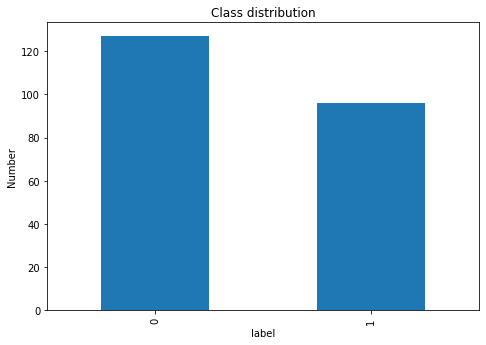

In [ ]:
import matplotlib.pyplot as plt

counts = testing_pd.groupby("label").size()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Create a bar plot
counts.plot(kind="bar")

# Show the plot
ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [ ]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

In [ ]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-34-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## 2-1 Get Accuracy

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
import numpy as np

# trainer.evaluate()

In [ ]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 223
  Batch size = 8


In [ ]:
#get test accuracy
pred.metrics

{'test_loss': 0.40024489164352417,
 'test_accuracy': 0.8834080717488789,
 'test_runtime': 9.3436,
 'test_samples_per_second': 23.867,
 'test_steps_per_second': 2.997}

In [ ]:
pred

PredictionOutput(predictions=array([[-2.5191777 ,  1.6862758 ],
       [-3.4968884 ,  2.873051  ],
       [ 2.742889  , -2.0270786 ],
       [-2.7512171 ,  1.9941837 ],
       [-3.3559706 ,  2.6883762 ],
       [ 1.6656094 , -0.8864222 ],
       [-2.7819102 ,  2.0254276 ],
       [ 2.2453198 , -1.4936615 ],
       [ 3.4167194 , -2.8076189 ],
       [ 3.1225636 , -2.47124   ],
       [ 2.059133  , -1.3128206 ],
       [ 1.937093  , -1.1701969 ],
       [ 3.6195414 , -3.0505195 ],
       [ 2.9655397 , -2.2820103 ],
       [-1.6373464 ,  1.0583715 ],
       [ 3.087615  , -2.4283807 ],
       [ 3.677114  , -3.0741284 ],
       [ 2.5019338 , -1.7660182 ],
       [-2.2514818 ,  1.3756661 ],
       [ 3.2102575 , -2.5847805 ],
       [ 2.1015465 , -1.3814867 ],
       [-1.9778743 ,  1.1182569 ],
       [ 2.4213655 , -1.6714909 ],
       [-2.3314612 ,  1.4303639 ],
       [ 2.5773897 , -1.8145771 ],
       [ 3.4753015 , -2.8938196 ],
       [ 1.8177168 , -1.0908437 ],
       [ 2.76362   , -2.04

In [ ]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0])

In [ ]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

# 3. Analyse predictions

In [ ]:

#look at all the results
testing_pd

,text,label,pred
0,国民党台北市长候选人蒋万安的太太石舫亘上周起开始帮忙分摊市场扫街行程，今天上午前往黄国梁资深...,1,1
1,长期关心台湾少子化问题，8月25日也曾发布“育儿生养政策”的国民党台北市长候选人蒋万安，传出...,1,1
2,资深媒体人周玉蔻近期大力支持民进党台北市长候选人陈时中，为此多次向国民党候选人蒋万安开炮，还...,0,0
3,蒋万安称，他是“正蓝军”，呼吁蓝营团结支持。 ​,1,1
4,日本学者预测，这次台北市长选举，国民党候选人蒋万安可能当选；民进党台北市长候选人陈时中今受访...,1,1
...,...,...,...
218,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0,0
219,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0,1
220,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0,1
221,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0,0


In [ ]:
#see where BERT got it wrong. The count column stands for how many comma's the sentence has... In case we want to consider removing some sentences. 
mistakes_pd = testing_pd.loc[testing_pd['label'] != testing_pd['pred']]
mistakes_pd = (mistakes_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
mistakes_pd['count'] = mistakes_pd['text'].str.count('，')
mistakes_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
95,#蒋万安赢得台北市长选举#赶紧开放自由行吧不想说了 ​,1,0,0
136,蒋介石的曾孙蒋万安当选中国台北市市长!老蒋的后代也不过如此嘛，才当了一个台北市二把手!#台湾# ​,0,1,1
89,#蒋万安赢得台北市长选举#对台湾人不报希望，换汤不换药。支持统一才是大事！ ​,0,1,1
5,全世界都在关注世界杯，只有我在关注台湾九合一选举如果我在台北，我会支持黄珊珊，但大概率蒋万安...,1,0,3
86,#蒋万安赢得台北市长选举#蒋万安就更搞笑了，既要又要既当又立还软骨头只想蹭蒋经国又要和凯申公...,0,1,3
57,#凤凰新闻#据台媒报道绿营名嘴周玉蔻近期猛打国民党台北市长参选人蒋万安，更抛出“验DNA”议...,0,1,4
21,据香港中评社报道，高端疫苗争议与民进党台北市长候选人陈时中“紧紧相扣”，影响其支持度。媒体人...,0,1,4
42,媒体人周玉蔻沉寂多时后，今（10）日正式复出广播节目，首位嘉宾邀请网红“四叉猫”。国民党台北...,0,1,4
44,台北市长柯文哲日前在脸书发布影片，酸台北市长蓝绿候选人蒋万安、陈时中，不要让不懂台北市的人，...,0,1,5


In [ ]:
#see where BERT got it right
correct_pd = testing_pd.loc[testing_pd['label'] == testing_pd['pred']]
correct_pd = (correct_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
correct_pd['count'] = correct_pd['text'].str.count('，')
correct_pd.sort_values(by="count")

In [ ]:
#correct_count_pd = correct_pd['text'].str.len()
#pd.DataFrame(correct_count_pd)